In [18]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import collections as mc
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
def tcluster(lines, eps, minlns):
  #Create array to hold cluster values
  Cluster = np.zeros(len(lines))
  #Set fist cluster to one
  cid = 1
  #For each trajectory
  for i in range(len(lines)):
    line = lines[i]

    #if the trajectory is unclassified, classify it or designate it as noise
    if Cluster[i]==0:
      #Get neighbors of a trajectory
      N = neighbor(line, eps, lines)
      #Check if trajectory has minimum number of neighbors
      if (len(N) >= minlns):
        #Give neighbors the cluster id
        for n in N:
          Cluster[n] = cid 
        queue = [n for n in N if n!=i]
        #Expand cluster based on neighbors of neighbor
        Cluster = expandcluster(queue, cid, eps, minlns, Cluster, lines)
        #Move to next cluster
        cid +=1
      #If line is unclassified and without enough neighbors to be it's own cluster designate it as noise
      else: 
        Cluster[i]= -1
  #Return list of cluster designations, with indices corresponding to trajectories' indices in lines array
  return Cluster

#Expland cluster based on neighbors of neighbor
def expandcluster(Q,cid,eps, minlns, Cluster, lines):
  while len(Q) != 0:
    M = Q.pop(0)
    line = lines[M]
    N = neighbor(line, eps, lines)
    if (len(N) >= minlns):
      for n in N:
        if Cluster[n] in [0,-1]:
          if Cluster[n]==0:
            Q.append(n)
          Cluster[n] = cid
    return Cluster
     
#Get trajectory neighbors
def neighbor(trajectory, eps, lines):
  distances = dist(trajectory, lines)
  neighbor_indices = np.where(distances <= eps)[0]
  return neighbor_indices

#Define deistance as sum of differences between two points
def dist(trajectory, lines):
  diff = np.absolute(np.subtract(lines, trajectory))
  distances = np.sum(diff, axis=1)
  return distances

In [7]:
def finallines(df):
  # Make lines of two longitude/latitude points
  def createlines(frame):
    # df_lines = pd.DataFrame(columns=["Long1, Lat1, Long2, Lat2"])
    frame.reset_index(inplace=True)
    # Get the lines in a day
    lines_day = [[frame.latitude[i], frame.longitude[i], frame.latitude[i + 1], frame.longitude[i + 1]] for i in
                 range(frame.shape[0] - 1)]
    # put the lines into a dataframe
    df_lines = pd.DataFrame(lines_day)
    return df_lines

  # convert datetime column to pandas datetime type
  df['datetime'] = pd.to_datetime(df['datetime'])
  # Create day column
  df['day'] = [int(datetime.datetime.date(d).day) for d in df['datetime']]
  # Groupby day and taxiid
  lines = df.groupby(['taxiid', 'day']).apply(createlines)

  # Reset index and convert to numpy array
  lines = lines.reset_index(drop=True)
  lines = lines.to_numpy()
  return lines

In [22]:
#Takes the lines array and cluster output and visualizes
def visclust(lines, clusters, noise = True):
    #Create plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    #Get number of clusters
    nclust = np.unique(clusters)

    #For each cluster
    for n in nclust:
        #Don't graph noise if specified not to
        if (noise == False and n == -1):
            continue
        #Get lines that are part of that cluster
        lines_index = lines[np.nonzero(clusters == n)]

        #Format lines into lists of tuples of points
        linesplt = []
        for l in lines_index:
            linesplt.append([tuple(l[0:2]), tuple(l[2:4])])

        #plot points in cluster
        x = [i[0] for j in linesplt for i in j]
        y = [i[1] for j in linesplt for i in j]
        p = ax.scatter(x, y, s=10, label="cluster " + str(n))

        #Get color of points
        color = p.get_facecolor()

        #Create and plot all lines in cluster
        lc = mc.LineCollection(linesplt, linewidths=2, color=color)
        ax.add_collection(lc)

    #Set labels and display plot
    ax.set_title("Taxi Trajectories Clustered by Trajectory")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.legend()
    plt.show()

In [4]:
df = pd.read_csv("/Users/tabithasugumar/Documents/Capstone/Data/Data/AllTaxi.csv")

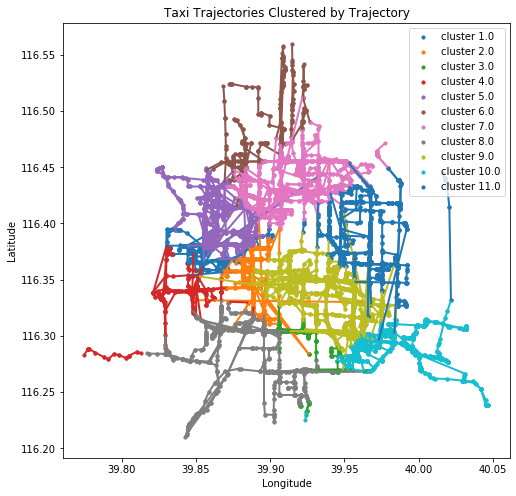

In [23]:
taxi2s = df[(df.taxiid == 8711)|(df.taxiid == 3644)]
lines = finallines(taxi2s)
clusters = tcluster(lines, .15, 500)
visclust(lines, clusters, False)

In [21]:
taxi1s = df[df.taxiid == 3644]

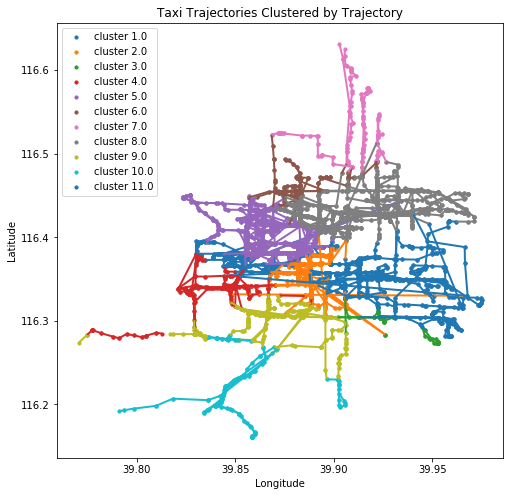

In [32]:
lines = finallines(taxi1s)
clusters = tcluster(lines, .15, 100)
visclust(lines, clusters, False)